<a href="https://colab.research.google.com/github/billybutcheroi/SkimLit/blob/main/SkimLit_nlp.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# SkimLit Project

The purpose of this notebook is to build a n NLP model to make reading medical abstract easier

In [1]:
#Confirm Access to GPU
!nvidia-smi -L

GPU 0: Tesla T4 (UUID: GPU-762e84cb-e6b7-2f9b-6be7-a4209499b168)


In [2]:
!git clone https://github.com/Franck-Dernoncourt/pubmed-rct.git

Cloning into 'pubmed-rct'...
remote: Enumerating objects: 39, done.
remote: Counting objects: 100% (14/14), done.
remote: Compressing objects: 100% (9/9), done.
remote: Total 39 (delta 8), reused 5 (delta 5), pack-reused 25 (from 1)
Receiving objects: 100% (39/39), 177.08 MiB | 16.00 MiB/s, done.
Resolving deltas: 100% (15/15), done.
Updating files: 100% (13/13), done.


#Get data

Since we'll be replicating the paper above(PubMEd 200k RCT), let's Download the datatset they used

In [3]:
!ls pubmed-rct

PubMed_200k_RCT				       PubMed_20k_RCT_numbers_replaced_with_at_sign
PubMed_200k_RCT_numbers_replaced_with_at_sign  README.md
PubMed_20k_RCT


In [4]:
!ls pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign

dev.txt  test.txt  train.txt


In [5]:
#Start our exp using the 20k dtatset with no.s replaced by @ sign
data_dir = "/content/pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/"

In [6]:
#Checkjing all the filenames in the target directory
import os
filename=[data_dir + filename for filename in os.listdir(data_dir)]
filename

['/content/pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/train.txt',
 '/content/pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/dev.txt',
 '/content/pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/test.txt']

## Preporcossed Data

Now we've got sme text data, we'll become one with the data

Visualize,Visualize,Visualize

In [7]:
#Create a fucntion to read the line of a document
def get_lines(filename):
  """
  Reads filenames (a text filename) and returns the lines of text as a list

  Args:
   filenames: a string conating the traget filepath

  Returns:
   A list of strings with one stirng per line
   """

  with open(filename,'r') as f:
   return f.readlines()

In [8]:
#Let's read the data
train_lines=get_lines(data_dir+"train.txt")
train_lines[:20]

['###24293578\n',
 'OBJECTIVE\tTo investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( OA ) .\n',
 'METHODS\tA total of @ patients with primary knee OA were randomized @:@ ; @ received @ mg/day of prednisolone and @ received placebo for @ weeks .\n',
 'METHODS\tOutcome measures included pain reduction and improvement in function scores and systemic inflammation markers .\n',
 'METHODS\tPain was assessed using the visual analog pain scale ( @-@ mm ) .\n',
 'METHODS\tSecondary outcome measures included the Western Ontario and McMaster Universities Osteoarthritis Index scores , patient global assessment ( PGA ) of the severity of knee OA , and @-min walk distance ( @MWD ) .\n',
 'METHODS\tSerum levels of interleukin @ ( IL-@ ) , IL-@ , tumor necrosis factor ( TNF ) - , and 

In [9]:
len(train_lines)

210040

##Let's think abt how we want our data to look

`[{'line_no.'}:0,
  'target':'BAckground'
  'text':'Emotional eating is associated with overeating and the development of obesity .\n''
  'total lines':11},
  ......]`

In [10]:
val_lines=get_lines(data_dir+"dev.txt")
test_lines=get_lines(data_dir+"test.txt")

In [11]:
def preprocess_text_with_line_numbers(filename):
    """
    Returns a list of dicts of abstract line data.

    Takes in a filename, reads its contents, and processes each line,
    extracting the target label, the sentence text, the sentence number,
    and the total number of sentences in the abstract.
    """
    input_lines = get_lines(filename)
    abstract_lines = ""  # Create an empty abstract
    abstract_samples = []  # Create an empty list of abstracts

    # Loop through each line in the target file
    for line in input_lines:
        if line.startswith("###"):  # Check if it's an ID line
            abstract_id = line
            abstract_lines = ""  # Reset the abstract string if line is an ID line

        elif line.isspace():  # Check if a line is a new line
            abstract_line_split = abstract_lines.splitlines()  # Split abstract into separate lines

            # Iterate through each line in a single abstract and count them
            for abstract_line_number, abstract_line in enumerate(abstract_line_split):
                line_data = {}  # Create an empty dict for each line
                target_text_split = abstract_line.split("\t")  # Split the line into target and text

                # Ensure the split has at least two elements
                if len(target_text_split) >= 2:
                    line_data["target"] = target_text_split[0]  # Get target label
                    line_data["text"] = target_text_split[1].lower()  # Get target text and lowercase it
                    line_data["line_number"] = abstract_line_number  # What line does the line appear in the abstract?
                    line_data["total_lines"] = len(abstract_line_split) - 1  # Total lines in the abstract
                    abstract_samples.append(line_data)  # Add line data to abstract sample list

        else:
            abstract_lines += line  # Accumulate lines into the current abstract

    return abstract_samples


In [12]:
# Get Data from file and prepocrss it
%%time
train_samples=preprocess_text_with_line_numbers(data_dir + "train.txt")
val_samples=preprocess_text_with_line_numbers(data_dir + "dev.txt")
test_samples=preprocess_text_with_line_numbers(data_dir + "test.txt")
print(len(train_samples), len(test_samples), len(val_samples))

180040 30135 30212
CPU times: user 567 ms, sys: 112 ms, total: 679 ms
Wall time: 1.26 s


In [13]:
train_samples[:10]

[{'target': 'OBJECTIVE',
  'text': 'to investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( oa ) .',
  'line_number': 0,
  'total_lines': 11},
 {'target': 'METHODS',
  'text': 'a total of @ patients with primary knee oa were randomized @:@ ; @ received @ mg/day of prednisolone and @ received placebo for @ weeks .',
  'line_number': 1,
  'total_lines': 11},
 {'target': 'METHODS',
  'text': 'outcome measures included pain reduction and improvement in function scores and systemic inflammation markers .',
  'line_number': 2,
  'total_lines': 11},
 {'target': 'METHODS',
  'text': 'pain was assessed using the visual analog pain scale ( @-@ mm ) .',
  'line_number': 3,
  'total_lines': 11},
 {'target': 'METHODS',
  'text': 'secondary outcome measures included the western ontari

In [14]:
import pandas as pd
train_df = pd.DataFrame(train_samples)
val_df = pd.DataFrame(val_samples)
test_df = pd.DataFrame(test_samples)
train_df.head(14)

,target,text,line_number,total_lines
0,OBJECTIVE,to investigate the efficacy of @ weeks of dail...,0,11
1,METHODS,a total of @ patients with primary knee oa wer...,1,11
2,METHODS,outcome measures included pain reduction and i...,2,11
3,METHODS,pain was assessed using the visual analog pain...,3,11
4,METHODS,secondary outcome measures included the wester...,4,11
5,METHODS,"serum levels of interleukin @ ( il-@ ) , il-@ ...",5,11
6,RESULTS,there was a clinically relevant reduction in t...,6,11
7,RESULTS,the mean difference between treatment arms ( @...,7,11
8,RESULTS,"further , there was a clinically relevant redu...",8,11
9,RESULTS,these differences remained significant at @ we...,9,11


In [15]:
#Distribuiiton of labels
train_df.target.value_counts()

,count
target,
METHODS,59353
RESULTS,57953
CONCLUSIONS,27168
BACKGROUND,21727
OBJECTIVE,13839


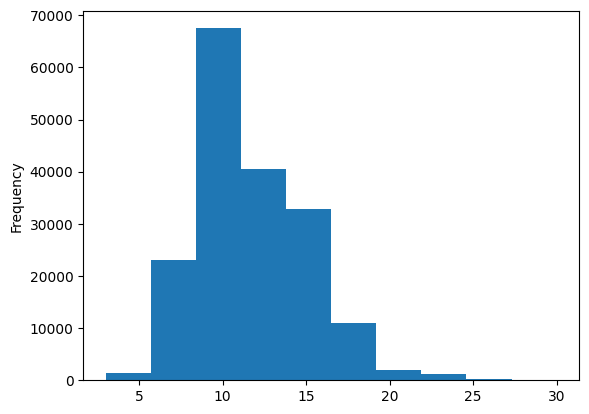

In [16]:
#Length of different lines
train_df.total_lines.plot.hist();

### Get list of sentences


In [17]:
#Convert abstract text lins into lists
train_sentences=train_df.text.to_list()
val_sentences=val_df.text.to_list()
test_sentences=test_df.text.to_list()
len(train_sentences),len(val_sentences),len(test_sentences)

(180040, 30212, 30135)

In [18]:
train1_sentences=train_df["text"].tolist()
val1_sentences=val_df["text"].tolist()
test1_sentences=test_df["text"].tolist()


In [19]:
#View the 10 lines of training sentences
train_sentences[:10]

['to investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( oa ) .',
 'a total of @ patients with primary knee oa were randomized @:@ ; @ received @ mg/day of prednisolone and @ received placebo for @ weeks .',
 'outcome measures included pain reduction and improvement in function scores and systemic inflammation markers .',
 'pain was assessed using the visual analog pain scale ( @-@ mm ) .',
 'secondary outcome measures included the western ontario and mcmaster universities osteoarthritis index scores , patient global assessment ( pga ) of the severity of knee oa , and @-min walk distance ( @mwd ) .',
 'serum levels of interleukin @ ( il-@ ) , il-@ , tumor necrosis factor ( tnf ) - , and high-sensitivity c-reactive protein ( hscrp ) were measured .',
 'there was a clinic

## Make numeric labels

In [20]:
# One hot encode labels
from sklearn.preprocessing import OneHotEncoder
one_hot_encoder = OneHotEncoder(sparse_output=False)#Tensorflow is incompatiable with sparse data type therefore turn it to false
train_labels_one_hot = one_hot_encoder.fit_transform(train_df["target"].to_numpy().reshape(-1,1))
val_labels_one_hot = one_hot_encoder.transform(val_df["target"].to_numpy().reshape(-1,1))
test_labels_one_hot = one_hot_encoder.transform(test_df["target"].to_numpy().reshape(-1,1))


train_labels_one_hot

array([[0., 0., 0., 1., 0.],
       [0., 0., 1., 0., 0.],
       [0., 0., 1., 0., 0.],
       ...,
       [0., 0., 0., 0., 1.],
       [0., 1., 0., 0., 0.],
       [0., 1., 0., 0., 0.]])

In [21]:
import tensorflow as tf
tf.constant(train_labels_one_hot)

<tf.Tensor: shape=(180040, 5), dtype=float64, numpy=
array([[0., 0., 0., 1., 0.],
       [0., 0., 1., 0., 0.],
       [0., 0., 1., 0., 0.],
       ...,
       [0., 0., 0., 0., 1.],
       [0., 1., 0., 0., 0.],
       [0., 1., 0., 0., 0.]])>

##Label encode labels

In [22]:
#Extract labels("target" columns) and encode them into integrs
from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()
train_labels_encoded = label_encoder.fit_transform(train_df["target"].to_numpy())
val_labels_encoded = label_encoder.transform(val_df["target"].to_numpy())
test_labels_encoded = label_encoder.transform(test_df["target"].to_numpy())

#Check what training labels look like
train_labels_encoded

array([3, 2, 2, ..., 4, 1, 1])

In [23]:
#Get class and numbre of classes from LabelEncoder
num_classes = len(label_encoder.classes_)
class_names = label_encoder.classes_
print(f"There are {num_classes} classes:\n{class_names}")


There are 5 classes:
['BACKGROUND' 'CONCLUSIONS' 'METHODS' 'OBJECTIVE' 'RESULTS']


##Starting a modelling exp

Baseline model-TF_IDF Multinomial Naive Baye's Clasifier

##Model 0:Getting a baseline model


In [24]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline

#Create a pipeline
model_0 = Pipeline([
    ('tf-idf' , TfidfVectorizer()),
     ('clf' , MultinomialNB())
])

#Fit the pipeline to the training data
model_0.fit(X=train_sentences,y=train_labels_encoded)

Pipeline(steps=[('tf-idf', TfidfVectorizer()), ('clf', MultinomialNB())])

In [25]:
#Evaluate baseline model on evaluation dataset
model_0.score(X=val_sentences,
              y=val_labels_encoded)

0.7218323844829869

In [26]:
#Make predicition using our baseline model
baseline_preds = model_0.predict(val_sentences)
baseline_preds

array([4, 1, 3, ..., 4, 4, 1])

##Diwnloasding helper fucntion scipt to evaluate the model

In [27]:
!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py

--2025-03-14 19:21:27--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10246 (10K) [text/plain]
Saving to: ‘helper_functions.py’

helper_functions.py 100%[===================>]  10.01K  --.-KB/s    in 0.001s  

2025-03-14 19:21:27 (17.5 MB/s) - ‘helper_functions.py’ saved [10246/10246]



In [28]:
from helper_functions import calculate_results

In [29]:
#Calulate baseline results
baseline_results = calculate_results(y_true=val_labels_encoded,
                                     y_pred=baseline_preds)
baseline_results

{'accuracy': 72.1832384482987,
 'precision': 0.7186466952323352,
 'recall': 0.7218323844829869,
 'f1': 0.6989250353450294}

In [30]:
train_sentences[:10]

['to investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( oa ) .',
 'a total of @ patients with primary knee oa were randomized @:@ ; @ received @ mg/day of prednisolone and @ received placebo for @ weeks .',
 'outcome measures included pain reduction and improvement in function scores and systemic inflammation markers .',
 'pain was assessed using the visual analog pain scale ( @-@ mm ) .',
 'secondary outcome measures included the western ontario and mcmaster universities osteoarthritis index scores , patient global assessment ( pga ) of the severity of knee oa , and @-min walk distance ( @mwd ) .',
 'serum levels of interleukin @ ( il-@ ) , il-@ , tumor necrosis factor ( tnf ) - , and high-sensitivity c-reactive protein ( hscrp ) were measured .',
 'there was a clinic

##Preparing our data(text) for deep sequence models

Before we start building deeper models, ve've got to create a vectorization

In [31]:
import numpy as np
import tensorflow as tf
from keras import layers


In [32]:
train_sentences[0]

'to investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( oa ) .'

In [33]:
#How long is a sentence
sent_lens = [len(sentence.split()) for sentence in train_sentences]
avg_sent_len = np.mean(sent_lens)
avg_sent_len

26.338269273494777

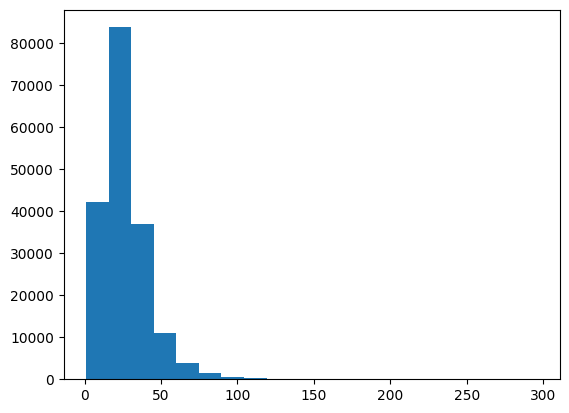

In [34]:
# what's the distribution looks like
import matplotlib.pyplot as plt
plt.hist(sent_lens , bins=20);

In [35]:
# How long of a sentence length covers 95% of example?
output_seq_len  = int(np.percentile(sent_lens,95))
output_seq_len

55

In [36]:
# Max sequnce length in training set
print(max(sent_lens))

296


## Create text vectorizer layer

We want to make a layer which maps our texts from words to numbers

In [37]:
# How many words are there in the vocabulary? (talken from table 2 of paper)
max_tokens=68000

In [38]:
#create text vectorizzer
from keras.layers import TextVectorization

text_vectorizer = TextVectorization(max_tokens=max_tokens,
                                    output_sequence_length=output_seq_len)#desired output length of vectorized sequence


In [39]:
#Adapt text vectorizer to training sentences
text_vectorizer.adapt(train_sentences)

In [40]:
#Test our text vect. on random senetces
import random
target_sentence = random.choice(train_sentences)
print(f"Text:\n{target_sentence}\n")
print(f"\nLength of text: {len(target_sentence)}")
print(f"Vectorized: {text_vectorizer([target_sentence])}")

Text:
this randomized , double-blind , placebo-controlled study was conducted in male patients aged between @ and @ years with mild to moderate hypertension .


Length of text: 152
Vectorized: [[ 23  29 236 329  17  10 198   5 564  12 307  30   3  64   7 533   6 362
  659   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0]]


In [41]:
#How many words in our training vocab.
rct_20k_text_vocab = text_vectorizer.get_vocabulary()
print(f"Number of words in vocab: {len(rct_20k_text_vocab)}")
print(f"Top 5 words: {rct_20k_text_vocab[:5]}")
print(f"Bottom 5 words: {rct_20k_text_vocab[62569]}")

Number of words in vocab: 64841
Top 5 words: ['', '[UNK]', 'the', 'and', 'of']
Bottom 5 words: bodyfat


In [42]:
# Get config of our etxt vectorizer
text_vectorizer.get_config()

{'name': 'text_vectorization',
 'trainable': True,
 'dtype': {'module': 'keras',
  'class_name': 'DTypePolicy',
  'config': {'name': 'float32'},
  'registered_name': None},
 'max_tokens': 68000,
 'standardize': 'lower_and_strip_punctuation',
 'split': 'whitespace',
 'ngrams': None,
 'output_mode': 'int',
 'output_sequence_length': 55,
 'pad_to_max_tokens': False,
 'sparse': False,
 'ragged': False,
 'vocabulary': None,
 'idf_weights': None,
 'encoding': 'utf-8',
 'vocabulary_size': 64841}

### Create custom token embedding

In [43]:
token_embed=layers.Embedding(input_dim=len(rct_20k_text_vocab),#Length of vocab
                             output_dim=128,#note: diffrent embedding sizes result in drastically different n umber of paramters
                             mask_zero=False,# use masking to handle variable sequence lengths (save space)
                             name='token_embedding')

In [44]:
#Show example embedding
print(f"Sentence before vectorization:\n {target_sentence}\n")
vectorized_sentence = text_vectorizer([target_sentence])
print(f"Sentence after vectorization (before embedding):\n: {vectorized_sentence}\n")
embedding_sentence = token_embed(vectorized_sentence)
print(f"Sentence after embedding:\n {embedding_sentence}\n")
print(f"Shape of embedding: {embedding_sentence.shape}")

Sentence before vectorization:
 this randomized , double-blind , placebo-controlled study was conducted in male patients aged between @ and @ years with mild to moderate hypertension .

Sentence after vectorization (before embedding):
: [[ 23  29 236 329  17  10 198   5 564  12 307  30   3  64   7 533   6 362
  659   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0]]

Sentence after embedding:
 [[[-0.01910825 -0.01391413 -0.02447157 ...  0.04600262 -0.03999373
   -0.01542765]
  [-0.04747466 -0.01323694 -0.01255453 ...  0.02815746  0.02557779
   -0.0290717 ]
  [ 0.01157551 -0.03611461  0.04079306 ...  0.00013063  0.01607157
    0.04014486]
  ...
  [-0.00058369  0.01678684  0.00303993 ... -0.00733208 -0.03142134
    0.04004915]
  [-0.00058369  0.01678684  0.00303993 ... -0.00733208 -0.03142134
    0.04004915]
  [-0.00058369  0.01678684  0.00303993 ... -0.00733208 -0.03142134
    0.04004915]]]

###Creating datasets (making sire our data load as fast as possible)

We're going to setup our datat to ruin as fast as possible with Tensorflow tf.data API , many of the steps here are discussed at lengtth in the two resources

In [45]:
#Turn our data to intop tensorflow datatsets
train_dataset = tf.data.Dataset.from_tensor_slices((train_sentences, train_labels_one_hot))
valid_dataset = tf.data.Dataset.from_tensor_slices((val_sentences, val_labels_one_hot))
test_dataset = tf.data.Dataset.from_tensor_slices((test_sentences , test_labels_one_hot))

train_dataset

<_TensorSliceDataset element_spec=(TensorSpec(shape=(), dtype=tf.string, name=None), TensorSpec(shape=(5,), dtype=tf.float64, name=None))>

In [46]:
#Take the TensorSliceDAatset's and turn them into prefetched datatsets
train_dataset = train_dataset.batch(32).prefetch(tf.data.AUTOTUNE)
valid_dataset = valid_dataset.batch(32).prefetch(tf.data.AUTOTUNE)
test_dataset = test_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

train_dataset

<_PrefetchDataset element_spec=(TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>

## Model 1:Conv 1D with token embeddings

In [47]:
from tensorflow import keras
from keras import layers

#Create 1D conv model to process sequences
inputs = layers.Input(shape=(1,), dtype=tf.string)
text_vectors = text_vectorizer(inputs) #vectorize text input
token_embeddings = token_embed(text_vectors)# create embedding
x=layers.Conv1D(64, kernel_size=5 ,padding="same", activation="relu")(token_embeddings)
x=layers.GlobalAveragePooling1D()(x)# condense tthe output of our feature vectors from conv layer
outputs= layers.Dense(num_classes, activation="softmax")(x)
model_1 = keras.Model(inputs, outputs, name="model_1_conv_1d")

#Compile
model_1.compile(loss="categorical_crossentropy",
                optimizer=keras.optimizers.Adam(),
                metrics=["accuracy"])

In [48]:
model_1.summary()




Model: "model_1_conv_1d"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 1)                   │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ text_vectorization                   │ (None, 55)                  │               0 │
│ (TextVectorization)                  │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ token_embedding (Embedding)          │ (None, 55, 128)             │       8,299,648 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d (Conv1D)                      │ (None, 55, 64)              │          41,024 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling1d             │ (None, 64)                  │               0 │
│ (GlobalAveragePooling1D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 5)                   │             325 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 8,340,997 (31.82 MB)

 Trainable params: 8,340,997 (31.82 MB)

 Non-trainable params: 0 (0.00 B)

In [49]:
#Fit the model
history_model_1= model_1.fit(train_dataset,
                             steps_per_epoch=int(0.1*len(train_dataset)),
                             epochs=3,
                             validation_data=valid_dataset,
                             validation_steps=int(0.1*len(valid_dataset)))

Epoch 1/3
562/562 ━━━━━━━━━━━━━━━━━━━━ 9s 11ms/step - accuracy: 0.5154 - loss: 1.1657 - val_accuracy: 0.7387 - val_loss: 0.6892
Epoch 2/3
562/562 ━━━━━━━━━━━━━━━━━━━━ 5s 9ms/step - accuracy: 0.7445 - loss: 0.6872 - val_accuracy: 0.7686 - val_loss: 0.6371
Epoch 3/3
562/562 ━━━━━━━━━━━━━━━━━━━━ 5s 10ms/step - accuracy: 0.7654 - loss: 0.6307 - val_accuracy: 0.7806 - val_loss: 0.6030


In [50]:
#Evalaute on whole validation
model_1.evaluate(valid_dataset)

945/945 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.7821 - loss: 0.6032


[0.6056320071220398, 0.7822719216346741]

In [51]:
#nmake predictions (our model predicts probabilites for each class)
model_1_pred_probs = model_1.predict(valid_dataset)
model_1_pred_probs, model_1_pred_probs.shape

945/945 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step


(array([[3.9924711e-01, 1.7294124e-01, 1.1586929e-01, 2.7540731e-01,
         3.6535066e-02],
        [4.6378088e-01, 2.9549381e-01, 8.6342078e-03, 2.2519360e-01,
         6.8974588e-03],
        [1.6887774e-01, 8.4187621e-03, 1.7606802e-03, 8.2092416e-01,
         1.8677143e-05],
        ...,
        [3.8806279e-06, 7.2485919e-04, 8.4700721e-04, 2.1866203e-06,
         9.9842203e-01],
        [4.7689520e-02, 4.7522494e-01, 1.0692950e-01, 4.8425246e-02,
         3.2173076e-01],
        [1.9329835e-01, 5.4800302e-01, 6.5860026e-02, 5.8193754e-02,
         1.3464484e-01]], dtype=float32),
 (30212, 5))

In [52]:
#Convert pered probs to classses
model_1_preds = tf.argmax(model_1_pred_probs, axis=1)
model_1_preds

<tf.Tensor: shape=(30212,), dtype=int64, numpy=array([0, 0, 3, ..., 4, 1, 1])>

In [53]:
#Calucate model_1 results
model_1_results = calculate_results(y_true=val_labels_encoded,
                                    y_pred=model_1_preds.cpu().numpy())
model_1_results

Instructions for updating:
Use tf.identity with explicit device placement instead.


{'accuracy': 78.22719449225474,
 'precision': 0.7784139860969453,
 'recall': 0.7822719449225474,
 'f1': 0.7796534638925762}

In [54]:
baseline_results

{'accuracy': 72.1832384482987,
 'precision': 0.7186466952323352,
 'recall': 0.7218323844829869,
 'f1': 0.6989250353450294}

###Model 2:Feature Exraction with pretrained token embeddings

##Building and Fitting an NLP feature extraction model from Tensorflow Hub

In [131]:
train_dataset = train_dataset.batch(32).prefetch(tf.data.AUTOTUNE)
valid_dataset = valid_dataset.batch(32).prefetch(tf.data.AUTOTUNE)


In [132]:
train_dataset = train_dataset.map(lambda x, y: (tf.squeeze(x), y))
valid_dataset = valid_dataset.map(lambda x, y: (tf.squeeze(x), y))


#Model 3: Conv1D with character embeddings

#Creating a charcater level tokenizer

In [133]:
# Make a fucntion to split sentences into characters
def split_chars(text):
  return " ".join (list(text))# joiun functon add

# Takes splitting non-charcater-lvl sequence into characters
split_chars(random_training_sentence), len(random_training_sentence)

('c p @   w a s   h i g h l y   e f f i c a c i o u s   a g a i n s t   b o t h   l e v e l s   o f   i n f e c t i o n   i n t e n s i t y   ,   r e s u l t i n g   i n   e r r   a n d   w r r   o f   m o r e   t h a n   @   %   .',
 115)

In [134]:
a = "hello"
print('a'.join(list(a)))

haealalao


In [135]:
# Split sequence-lvl data spits into charcters-lvl data splits
train_chars = [split_chars(sentence) for sentence in train_sentences]
val_chars = [split_chars(sentence) for sentence in val_sentences]
test_chars = [split_chars(sentence) for sentence in test_sentences]
print(train_chars[2])

o u t c o m e   m e a s u r e s   i n c l u d e d   p a i n   r e d u c t i o n   a n d   i m p r o v e m e n t   i n   f u n c t i o n   s c o r e s   a n d   s y s t e m i c   i n f l a m m a t i o n   m a r k e r s   .


In [136]:
# What's the averagre character length??
char_lens = [len(sentence) for sentence in train_sentences]
mean_char_len = np.mean(char_lens)
mean_char_len, len(train_chars[2])

(149.3662574983337, 221)

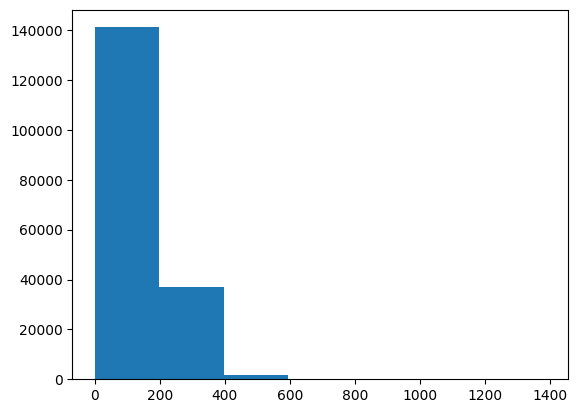

In [137]:
# Check the distribution of our sequences at character-lvl
import matplotlib.pyplot as plt
plt.hist(char_lens,bins=7);

In [138]:
# Find what charcater length covers 95% of our sequences
output_seq_char_len = int(np.percentile(char_lens, 95))
output_seq_char_len

290

In [139]:
# Get all the keyboard characters for char-lvl embedding
import string
alphabet = string.ascii_lowercase + string.digits + string.punctuation
alphabet

'abcdefghijklmnopqrstuvwxyz0123456789!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~'

In [140]:
# Create char-lvl token vectorizer instance
NUM_CHAR_TOKENS = len(alphabet) + 2
char_vectorizer = TextVectorization(max_tokens=NUM_CHAR_TOKENS,
                                     output_sequence_length = output_seq_char_len,
                                     standardize=  "lower_and_strip_punctuation",
                                     name="char_vectorizer")

char_vectorizer.adapt(train_chars)

In [141]:
char_vocab = char_vectorizer.get_vocabulary()
print(f"Number of different characters in charcater vocab: {len(char_vocab)}")
print(f"5 most common character: {char_vocab[:5]}")
print(f"5 least common character: {char_vocab[-5:]}")
print(len(char_vocab))

Number of different characters in charcater vocab: 28
5 most common character: ['', '[UNK]', 'e', 't', 'i']
5 least common character: ['k', 'x', 'z', 'q', 'j']
28


In [142]:
# Test our charcter vectorizer
random_train_chars = random.choice(train_chars)
print(f"Text: {random_train_chars}\n")
print(f"Vectorized: {char_vectorizer([random_train_chars])}")

Text: c l i n i c a l t r i a l s . g o v   i d e n t i f i e r   :   n c t @   .

Vectorized: [[11 12  4  6  4 11  5 12  3  8  4  5 12  9 18  7 21  4 10  2  6  3  4 17
   4  2  8  6 11  3  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0]]


#Creating a charcter lvl embedding


In [143]:
# Create char embedding layer
char_embed = layers.Embedding(input_dim=NUM_CHAR_TOKENS,
                              output_dim=25,
                              mask_zero=False,
                              name="char_embed")

#Test our character embedding layer
print(f"Text: {random_train_chars}\n")
print(f"Vectorized: {char_vectorizer([random_train_chars])}\n")
print(f"Embedded: {char_embed(char_vectorizer([random_train_chars]))}")

Text: c l i n i c a l t r i a l s . g o v   i d e n t i f i e r   :   n c t @   .

Vectorized: [[11 12  4  6  4 11  5 12  3  8  4  5 12  9 18  7 21  4 10  2  6  3  4 17
   4  2  8  6 11  3  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0]]

Embedd

##Building a Conv1D model to fit on character embeddings

In [144]:
import os

# Setting the environment variable to use only CPU (if necessary)
os.environ["CUDA_VISIBLE_DEVICES"] = "-1"

In [145]:
# Make Conv1D on chars only
inputs = layers.Input(shape=(1,), dtype="string")
char_vectors = char_vectorizer(inputs)
char_embeddings = char_embed(char_vectors)
x = layers.Conv1D(64, kernel_size=5, padding="same", activation="relu")(char_embeddings)
x = layers.GlobalMaxPool1D()(x)
outputs = layers.Dense(5, activation="softmax")(x)
model_3 = tf.keras.Model(inputs, outputs, name="model_3_char_cnn")

# Compile
model_3.compile(loss="categorical_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

In [146]:
model_3.summary()

Model: "model_3_char_cnn"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_3 (InputLayer)           │ (None, 1)                   │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ char_vectorizer (TextVectorization)  │ (None, 290)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ char_embed (Embedding)               │ (None, 290, 25)             │           1,750 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_2 (Conv1D)                    │ (None, 290, 64)             │           8,064 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_max_pooling1d_1               │ (None, 64)                  │               0 │
│ (GlobalMaxPooling1D)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_9 (Dense)                      │ (None, 5)                   │             325 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 10,139 (39.61 KB)

 Trainable params: 10,139 (39.61 KB)

 Non-trainable params: 0 (0.00 B)

In [147]:
train_char_dataset = tf.data.Dataset.from_tensor_slices((train_chars, train_labels_one_hot)).batch(32).prefetch(tf.data.AUTOTUNE)
val_char_dataset = tf.data.Dataset.from_tensor_slices((val_chars, val_labels_one_hot)).batch(32).prefetch(tf.data.AUTOTUNE)

train_char_dataset

<_PrefetchDataset element_spec=(TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>

In [148]:


# ... (Rest of the code remains unchanged) ...

model_3_history = model_3.fit(train_char_dataset,
                              steps_per_epoch=int(0.1*len(train_char_dataset)),
                              epochs=3,
                              validation_data=val_char_dataset,
                              validation_steps=int(0.1*len(val_char_dataset)))

Epoch 1/3
562/562 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - accuracy: 0.4119 - loss: 1.4195 - val_accuracy: 0.5811 - val_loss: 1.0623
Epoch 2/3
562/562 ━━━━━━━━━━━━━━━━━━━━ 5s 9ms/step - accuracy: 0.5893 - loss: 1.0346 - val_accuracy: 0.6340 - val_loss: 0.9374
Epoch 3/3
562/562 ━━━━━━━━━━━━━━━━━━━━ 5s 9ms/step - accuracy: 0.6322 - loss: 0.9341 - val_accuracy: 0.6669 - val_loss: 0.8658


In [149]:
model_3.evaluate(val_char_dataset)

945/945 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.6592 - loss: 0.8757


[0.875042200088501, 0.6597709655761719]

In [150]:
# MAke preicitions
model_3_pred_probs = model_3.predict(val_char_dataset)
model_3_pred_probs

945/945 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step


array([[0.220887  , 0.43761835, 0.06312835, 0.23535837, 0.04300787],
       [0.11882392, 0.6387962 , 0.01041035, 0.1778015 , 0.05416801],
       [0.14696439, 0.20467761, 0.13965274, 0.41605845, 0.09264683],
       ...,
       [0.03523304, 0.06242876, 0.12223468, 0.03519314, 0.7449103 ],
       [0.03752138, 0.08485976, 0.36526966, 0.02705953, 0.48528963],
       [0.4226197 , 0.4079864 , 0.07244572, 0.09038351, 0.00656461]],
      dtype=float32)

In [151]:
# Convert predicitons to classes
model_3_preds = tf.argmax(model_3_pred_probs, axis=1)
model_3_preds

<tf.Tensor: shape=(30212,), dtype=int64, numpy=array([1, 1, 3, ..., 4, 4, 0])>

In [152]:
model_3_results = calculate_results(y_true=val_labels_encoded,
                                  y_pred=model_3_preds.cpu().numpy())
model_3_results

{'accuracy': 65.97709519396267,
 'precision': 0.6543264335536311,
 'recall': 0.6597709519396266,
 'f1': 0.6469369481046318}

In [153]:
model_1_results


{'accuracy': 78.22719449225474,
 'precision': 0.7784139860969453,
 'recall': 0.7822719449225474,
 'f1': 0.7796534638925762}

#Model 4:Combining pretrained token embeddings + character embdeddings (hybrid embedding layer)

In [154]:
# 1. Setup token inputs/model
token_inputs = layers.Input(shape=[], dtype=tf.string, name="token_input")
token_embeddings =layers.Lambda(lambda x: tf_hub_embedding_layer(tf.cast(x, tf.string)))(token_inputs)
token_output = layers.Dense(128, activation="relu")(token_embeddings)
token_model = tf.keras.Model(inputs=token_inputs,
                             outputs=token_output)

# 2. Setup char inputs/model
char_inputs = layers.Input(shape=(1,), dtype=tf.string, name="char_input")
char_vectors = char_vectorizer(char_inputs)
char_embeddings = char_embed(char_vectors)
char_bi_lstm = layers.Bidirectional(layers.LSTM(24))(char_embeddings) # bi-LSTM shown in Figure 1 of https://arxiv.org/pdf/1612.05251.pdf
char_model = tf.keras.Model(inputs=char_inputs,
                            outputs=char_bi_lstm)

# 3. Concatenate token and char inputs (create hybrid token embedding)
token_char_concat = layers.Concatenate(name="token_char_hybrid")([token_model.output,
                                                                  char_model.output])

# 4. Create output layers - addition of dropout discussed in 4.2 of https://arxiv.org/pdf/1612.05251.pdf
combined_dropout = layers.Dropout(0.5)(token_char_concat)
combined_dense = layers.Dense(128, activation="relu")(combined_dropout) # slightly different to Figure 1 due to different shapes of token/char embedding layers
final_dropout = layers.Dropout(0.5)(combined_dense)
output_layer = layers.Dense(num_classes, activation="softmax")(final_dropout)

# 5. Construct model with char and token inputs
model_4 = tf.keras.Model(inputs=[token_model.input, char_model.input],
                         outputs=output_layer,
                         name="model_4_token_and_char_embeddings")

In [155]:
model_4.summary()

Model: "model_4_token_and_char_embeddings"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ char_input (InputLayer)   │ (None, 1)              │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ token_input (InputLayer)  │ (None)                 │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ char_vectorizer           │ (None, 290)            │              0 │ char_input[0][0]       │
│ (TextVectorization)       │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ lambda_2 (Lambda)         │ (None, 512)            │              0 │ token_input[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ char_embed (Embedding)    │ (None, 290, 25)        │          1,750 │ char_vectorizer[1][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_10 (Dense)          │ (None, 128)            │         65,664 │ lambda_2[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ bidirectional_2           │ (None, 48)             │          9,600 │ char_embed[1][0]       │
│ (Bidirectional)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ token_char_hybrid         │ (None, 176)            │              0 │ dense_10[0][0],        │
│ (Concatenate)             │                        │                │ bidirectional_2[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_3 (Dropout)       │ (None, 176)            │              0 │ token_char_hybrid[0][… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_11 (Dense)          │ (None, 128)            │         22,656 │ dropout_3[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_4 (Dropout)       │ (None, 128)            │              0 │ dense_11[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_12 (Dense)          │ (None, 5)              │            645 │ dropout_4[0][0]        │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 100,315 (391.86 KB)

 Trainable params: 100,315 (391.86 KB)

 Non-trainable params: 0 (0.00 B)

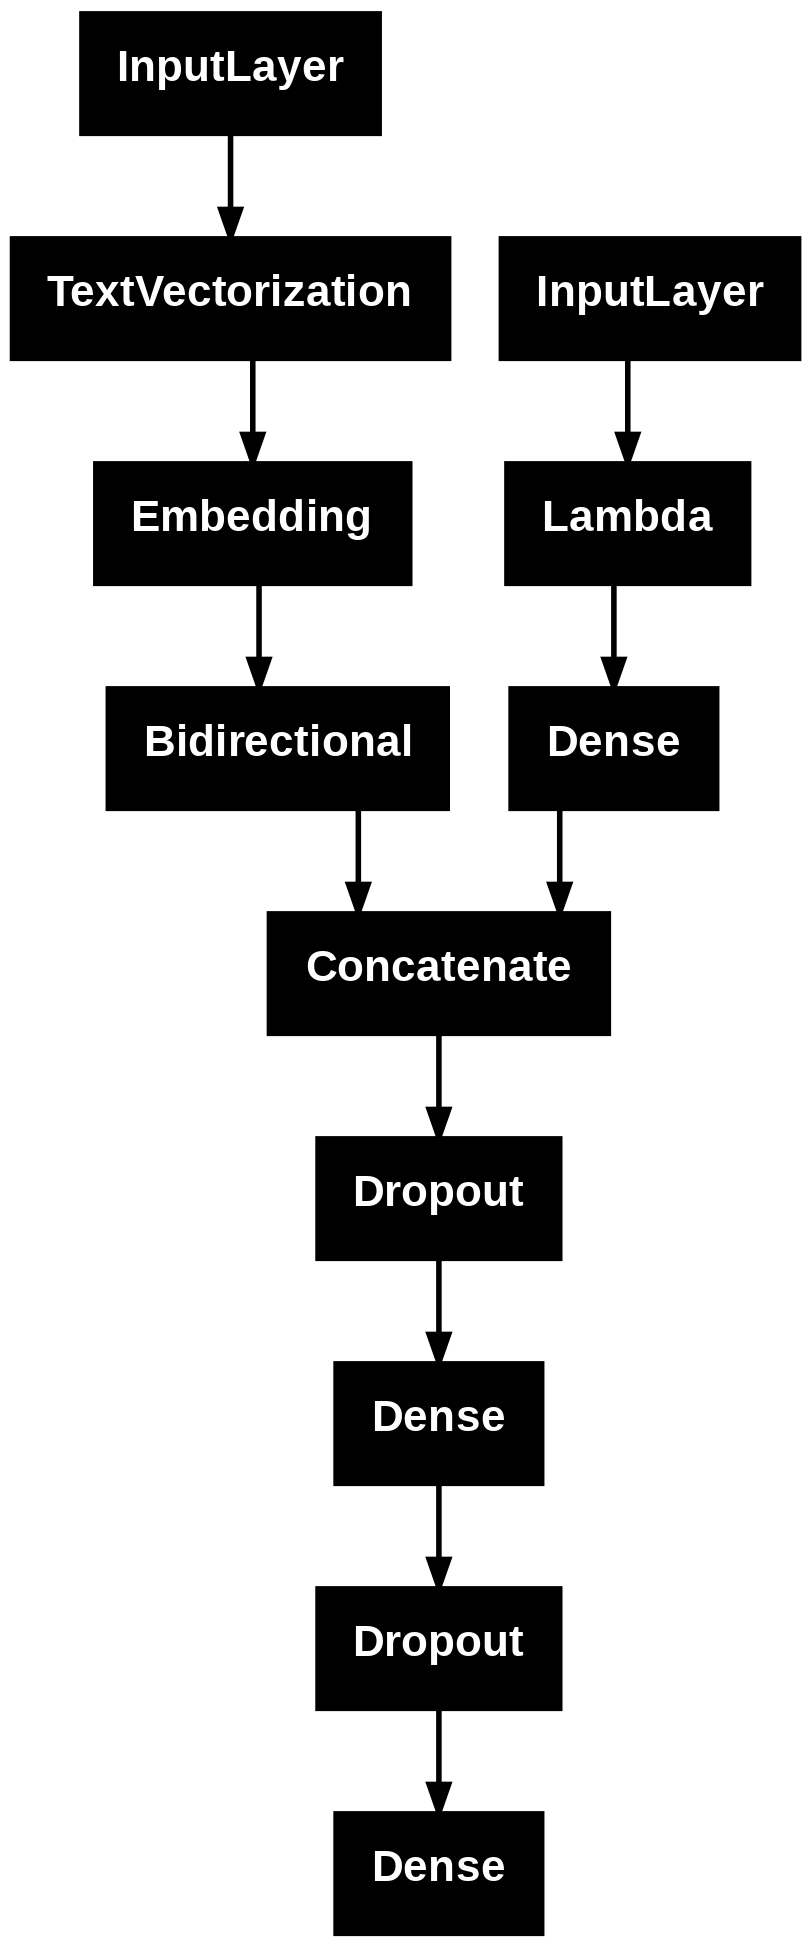

In [156]:
# Plot hybrid token and character model
from tensorflow.keras.utils import plot_model
plot_model(model_4)

In [157]:
# Compile token char  model
model_4.compile(loss="categorical_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

##Combining token and character data into a `tf.data` dataset

In [158]:
# Combine chars and tokens into a dataset
train_char_token_data = tf.data.Dataset.from_tensor_slices((train_chars, train_sentences))
train_char_token_labels =tf.data.Dataset.from_tensor_slices(train_labels_one_hot)
train_char_token_dataset = tf.data.Dataset.zip((train_char_token_data, train_char_token_labels))


#Prefetch and batch train data
train_char_token_dataset = train_char_token_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

#Repeat the same for validaiton data
val_char_token_data = tf.data.Dataset.from_tensor_slices((val_chars, val_sentences))
val_char_token_labels = tf.data.Dataset.from_tensor_slices(val_labels_one_hot)
val_char_token_dataset = tf.data.Dataset.zip((val_char_token_data, val_char_token_labels))
val_char_token_dataset = val_char_token_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

In [159]:
train_char_token_dataset, val_char_token_dataset

(<_PrefetchDataset element_spec=((TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None)), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>,
 <_PrefetchDataset element_spec=((TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None)), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>)

In [160]:
# Fit the model
model_4_history = model_4.fit(train_char_token_dataset,
                               steps_per_epoch=int(0.1*len(train_char_token_dataset)),
                               epochs=3,
                               validation_data=val_char_token_dataset,
                               validation_steps=int(0.1*len(val_char_token_dataset)))

Epoch 1/3
562/562 ━━━━━━━━━━━━━━━━━━━━ 109s 37ms/step - accuracy: 0.3447 - loss: 1.4553 - val_accuracy: 0.5020 - val_loss: 1.1767
Epoch 2/3
562/562 ━━━━━━━━━━━━━━━━━━━━ 41s 73ms/step - accuracy: 0.4945 - loss: 1.2031 - val_accuracy: 0.5492 - val_loss: 1.1112
Epoch 3/3
562/562 ━━━━━━━━━━━━━━━━━━━━ 21s 37ms/step - accuracy: 0.5175 - loss: 1.1520 - val_accuracy: 0.5535 - val_loss: 1.0882


In [161]:
model_4.evaluate(val_char_token_dataset)

945/945 ━━━━━━━━━━━━━━━━━━━━ 22s 23ms/step - accuracy: 0.5503 - loss: 1.0885


[1.089551568031311, 0.5505428314208984]

In [162]:
# Make predicitions using the token-character model hybrid
model_4_pred_probs = model_4.predict(val_char_token_dataset)
model_4_pred_probs

945/945 ━━━━━━━━━━━━━━━━━━━━ 21s 21ms/step


array([[0.2346867 , 0.3068402 , 0.13722523, 0.22984916, 0.09139867],
       [0.0751765 , 0.23107606, 0.1775252 , 0.06684992, 0.44937226],
       [0.17308043, 0.22948867, 0.27419016, 0.18523729, 0.13800342],
       ...,
       [0.15120508, 0.3041765 , 0.16171496, 0.14562333, 0.23728012],
       [0.10128023, 0.21042332, 0.27382514, 0.10490555, 0.3095658 ],
       [0.3051393 , 0.2966439 , 0.15327759, 0.14931373, 0.0956255 ]],
      dtype=float32)

In [163]:
# Turn predictions probabilities into prdicition clalsses
model_4_preds = tf.argmax(model_4_pred_probs, axis=1)
model_4_preds

<tf.Tensor: shape=(30212,), dtype=int64, numpy=array([1, 4, 2, ..., 1, 4, 0])>

In [164]:
# Get the results of token-char-hybrid model
model_4_results = calculate_results(y_true = val_labels_encoded,
                                    y_pred = model_4_preds.numpy())
model_4_results

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


{'accuracy': 55.05428306633126,
 'precision': 0.5471667610590606,
 'recall': 0.5505428306633126,
 'f1': 0.5184755605387905}

###Model 5: Transfer Learning with pretrained token embeddings + character embeddings + positional embeddings

The process of applying your own knowledge to build features as input to a model is called `feature enginerring`

In [165]:
train_df.head()

,target,text,line_number,total_lines
0,OBJECTIVE,to investigate the efficacy of @ weeks of dail...,0,11
1,METHODS,a total of @ patients with primary knee oa wer...,1,11
2,METHODS,outcome measures included pain reduction and i...,2,11
3,METHODS,pain was assessed using the visual analog pain...,3,11
4,METHODS,secondary outcome measures included the wester...,4,11


#Create positional embeddings


In [166]:
# How mamny different line numbers are there?
train_df["line_number"].value_counts()

,count
line_number,
0,15000
1,15000
2,15000
3,15000
4,14992
5,14949
6,14758
7,14279
8,13346


<Axes: ylabel='Frequency'>

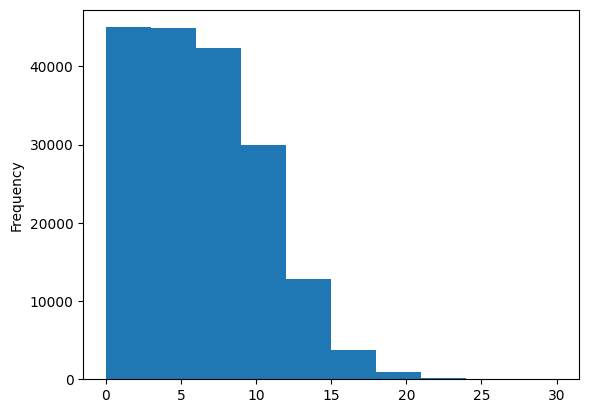

In [167]:
# Check the distribution of "line_number" column
train_df["line_number"].plot.hist()

In [168]:
# Use tensorflow to create one-hot-encoded tensors of our line_number column
train_line_numbers_one_hot = tf.one_hot(train_df["line_number"].to_numpy(), depth=15)
val_line_numbers_one_hot = tf.one_hot(val_df["line_number"].to_numpy(), depth=15)
test_line_numbers_one_hot = tf.one_hot(test_df["line_number"].to_numpy(), depth=15)

In [169]:
# Check the one-hot-encoded "line_numebr" feature samples
train_line_numbers_one_hot.shape, train_line_numbers_one_hot[:20]

(TensorShape([180040, 15]),
 <tf.Tensor: shape=(20, 15), dtype=float32, numpy=
 array([[1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0.

In [170]:
# How many different number of lines are there?
train_df["total_lines"].value_counts()

,count
total_lines,
11,24468
10,23639
12,22113
9,19400
13,18438
14,14610
8,12285
15,10768
7,7464


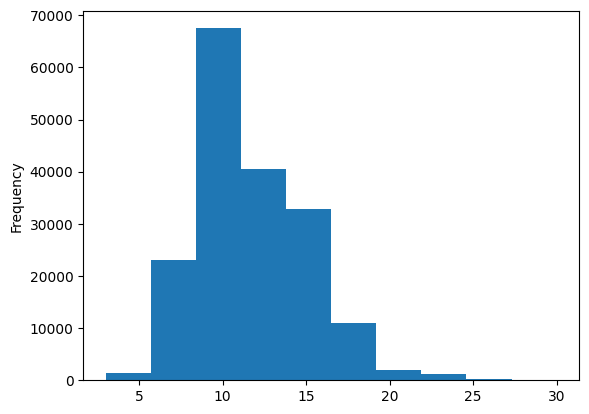

In [171]:
train_df.total_lines.plot.hist();

In [172]:
# Check the coverage of a "total_lines" value of 20
np.percentile(train_df.total_lines,98)

20.0

In [173]:
train_total_lines_one_hot = tf.one_hot(train_df["total_lines"].to_numpy(), depth=20)
val_total_lines_one_hot = tf.one_hot(val_df["total_lines"].to_numpy(), depth=20)
test_total_lines_one_hot = tf.one_hot(test_df["total_lines"].to_numpy(), depth=20)

#Check shape and samples of total lines one-hot tensor
train_total_lines_one_hot.shape, train_total_lines_one_hot[:10]

(TensorShape([180040, 20]),
 <tf.Tensor: shape=(10, 20), dtype=float32, numpy=
 array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0

#Building a tribrid embedding model

In [174]:
# 1. Token inputs
# 1. Token inputs
token_inputs = layers.Input(shape=[], dtype="string", name="token_inputs")
token_embeddings = layers.Lambda(lambda x: tf_hub_embedding_layer(tf.cast(x, tf.string)), output_shape=(512,))(token_inputs)  # Wrap with Lambda and specify output_shape
token_outputs = layers.Dense(128, activation="relu")(token_embeddings)
token_model = tf.keras.Model(inputs=token_inputs,
                             outputs=token_outputs)

# ... (Rest of the code remains unchanged) ...

# 2. Char inputs
char_inputs = layers.Input(shape=(1,), dtype="string", name="char_inputs")
char_vectors = char_vectorizer(char_inputs)
char_embeddings = char_embed(char_vectors)
char_bi_lstm = layers.Bidirectional(layers.LSTM(32))(char_embeddings)
char_model = tf.keras.Model(inputs=char_inputs,
                            outputs=char_bi_lstm)

# 3. Line numbers inputs
line_number_inputs = layers.Input(shape=(15,), dtype=tf.float32, name="line_number_input")
x = layers.Dense(32, activation="relu")(line_number_inputs)
line_number_model = tf.keras.Model(inputs=line_number_inputs,
                                   outputs=x)

# 4. Total lines inputs
total_lines_inputs = layers.Input(shape=(20,), dtype=tf.float32, name="total_lines_input")
y = layers.Dense(32, activation="relu")(total_lines_inputs)
total_line_model = tf.keras.Model(inputs=total_lines_inputs,
                                  outputs=y)

# 5. Combine token and char embeddings into a hybrid embedding
combined_embeddings = layers.Concatenate(name="token_char_hybrid_embedding")([token_model.output,
                                                                              char_model.output])
z = layers.Dense(256, activation="relu")(combined_embeddings)
z = layers.Dropout(0.5)(z)

# 6. Combine positional embeddings with combined token and char embeddings into a tribrid embedding
z = layers.Concatenate(name="token_char_positional_embedding")([line_number_model.output,
                                                                total_line_model.output,
                                                                z])

# 7. Create output layer
output_layer = layers.Dense(5, activation="softmax", name="output_layer")(z)

# 8. Put together model
model_5 = tf.keras.Model(inputs=[line_number_model.input,
                                 total_line_model.input,
                                 token_model.input,
                                 char_model.input],
                         outputs=output_layer)


In [175]:
model_5.summary()

Model: "functional_13"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ char_inputs (InputLayer)  │ (None, 1)              │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ token_inputs (InputLayer) │ (None)                 │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ char_vectorizer           │ (None, 290)            │              0 │ char_inputs[0][0]      │
│ (TextVectorization)       │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ lambda_3 (Lambda)         │ (None, 512)            │              0 │ token_inputs[0][0]     │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ char_embed (Embedding)    │ (None, 290, 25)        │          1,750 │ char_vectorizer[2][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_13 (Dense)          │ (None, 128)            │         65,664 │ lambda_3[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ bidirectional_3           │ (None, 64)             │         14,848 │ char_embed[2][0]       │
│ (Bidirectional)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ token_char_hybrid_embedd… │ (None, 192)            │              0 │ dense_13[0][0],        │
│ (Concatenate)             │                        │                │ bidirectional_3[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ line_number_input         │ (None, 15)             │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ total_lines_input         │ (None, 20)             │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_16 (Dense)          │ (None, 256)            │         49,408 │ token_char_hybrid_emb… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_14 (Dense)          │ (None, 32)             │            512 │ line_number_input[0][… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_15 (Dense)          │ (None, 32)             │            672 │ total_lines_input[0][… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_5 (Dropout)       │ (None, 256)            │              0 │ dense_16[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ token_char_positional_em… │ (None, 320)            │              0 │ dense_14[0][0],        │
│ (Concatenate)             │                        │                │ dense_15[0][0],        │
│                           │                        │                │ dropout_5[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ output_layer (Dense)      │ (None, 5)              │          1,605 │ token_char_positional… │
└──────────────────────

 Total params: 134,459 (525.23 KB)

 Trainable params: 134,459 (525.23 KB)

 Non-trainable params: 0 (0.00 B)

In [176]:
# Check which layers of our model are trainable or not
for layer in model_5.layers:
  print(layer.name, layer.trainable)

char_inputs True
token_inputs True
char_vectorizer True
lambda_3 True
char_embed True
dense_13 True
bidirectional_3 True
token_char_hybrid_embedding True
line_number_input True
total_lines_input True
dense_16 True
dense_14 True
dense_15 True
dropout_5 True
token_char_positional_embedding True
output_layer True


In [177]:
#Compile token,char,positional embedding model
model_5.compile(loss = tf.keras.losses.CategoricalCrossentropy(label_smoothing=0.2),
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

In [178]:
 #Create training and validation datasets (all four kinds of inputs)
train_pos_char_token_data = tf.data.Dataset.from_tensor_slices((train_line_numbers_one_hot, # line numbers
                                                                train_total_lines_one_hot, # total lines
                                                                train_sentences, # train tokens
                                                                train_chars)) # train chars
train_pos_char_token_labels = tf.data.Dataset.from_tensor_slices(train_labels_one_hot) # train labels
train_pos_char_token_dataset = tf.data.Dataset.zip((train_pos_char_token_data, train_pos_char_token_labels)) # combine data and labels
train_pos_char_token_dataset = train_pos_char_token_dataset.batch(32).prefetch(tf.data.AUTOTUNE) # turn into batches and prefetch appropriately

# Validation dataset
val_pos_char_token_data = tf.data.Dataset.from_tensor_slices((val_line_numbers_one_hot,
                                                              val_total_lines_one_hot,
                                                              val_sentences,
                                                              val_chars))
val_pos_char_token_labels = tf.data.Dataset.from_tensor_slices(val_labels_one_hot)
val_pos_char_token_dataset = tf.data.Dataset.zip((val_pos_char_token_data, val_pos_char_token_labels))
val_pos_char_token_dataset = val_pos_char_token_dataset.batch(32).prefetch(tf.data.AUTOTUNE) # turn into batches and prefetch appropriately

# Check input shapes
train_pos_char_token_dataset, val_pos_char_token_dataset

(<_PrefetchDataset element_spec=((TensorSpec(shape=(None, 15), dtype=tf.float32, name=None), TensorSpec(shape=(None, 20), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None)), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>,
 <_PrefetchDataset element_spec=((TensorSpec(shape=(None, 15), dtype=tf.float32, name=None), TensorSpec(shape=(None, 20), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None)), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>)

In [179]:
for batch in train_pos_char_token_dataset.take(1):
    data, labels = batch
    for input_data in data:
        print(input_data.shape)


(32, 15)
(32, 20)
(32,)
(32,)


In [180]:
# Fit the token, char and positional embedding model
history_model_5 = model_5.fit(train_pos_char_token_dataset,
                              steps_per_epoch=int(0.1 * len(train_pos_char_token_dataset)),
                              epochs=3,
                              validation_data=val_pos_char_token_dataset,
                              validation_steps=int(0.1 * len(val_pos_char_token_dataset)))

Epoch 1/3
562/562 ━━━━━━━━━━━━━━━━━━━━ 22s 33ms/step - accuracy: 0.6077 - loss: 1.2385 - val_accuracy: 0.8072 - val_loss: 0.9827
Epoch 2/3
562/562 ━━━━━━━━━━━━━━━━━━━━ 20s 36ms/step - accuracy: 0.8096 - loss: 0.9720 - val_accuracy: 0.8251 - val_loss: 0.9486
Epoch 3/3
562/562 ━━━━━━━━━━━━━━━━━━━━ 42s 75ms/step - accuracy: 0.8207 - loss: 0.9535 - val_accuracy: 0.8368 - val_loss: 0.9371


In [181]:
#Make predicitions with token-char-positional hybrid model
model_5_pred_probs = model_5.predict(val_pos_char_token_dataset)
model_5_pred_probs

945/945 ━━━━━━━━━━━━━━━━━━━━ 17s 17ms/step


array([[0.4879966 , 0.10291411, 0.00994831, 0.3816518 , 0.01748925],
       [0.50618297, 0.09241723, 0.04309988, 0.3486204 , 0.00967951],
       [0.29538432, 0.12008253, 0.11064141, 0.41673133, 0.0571605 ],
       ...,
       [0.03481045, 0.10917694, 0.03783844, 0.03124119, 0.786933  ],
       [0.02172575, 0.28264636, 0.07196843, 0.02164644, 0.60201305],
       [0.23108102, 0.5541062 , 0.10464445, 0.04058207, 0.06958625]],
      dtype=float32)

In [182]:
# Turn prediction probabilities into prediction classes
model_5_preds = tf.argmax(model_5_pred_probs, axis=1)
model_5_preds

<tf.Tensor: shape=(30212,), dtype=int64, numpy=array([0, 0, 3, ..., 4, 4, 1])>

In [183]:
# Calculate results of token-char-positional hybrid model
model_5_results = calculate_results(y_true=val_labels_encoded,
                                    y_pred=model_5_preds.numpy())
model_5_results

{'accuracy': 83.22520852641334,
 'precision': 0.8310534188202564,
 'recall': 0.8322520852641334,
 'f1': 0.8314391464682908}

In [184]:
# Combine model results into a DataFrame
all_model_results = pd.DataFrame({"baseline": baseline_results,
                                  "custom_token_embed_conv1d": model_1_results,

                                  "custom_char_embed_conv1d": model_3_results,
                                  "hybrid_char_token_embed": model_4_results,
                                  "tribrid_pos_char_token_embed": model_5_results})
all_model_results = all_model_results.transpose()
all_model_results

,accuracy,precision,recall,f1
baseline,72.183238,0.718647,0.721832,0.698925
custom_token_embed_conv1d,78.227194,0.778414,0.782272,0.779653
custom_char_embed_conv1d,65.977095,0.654326,0.659771,0.646937
hybrid_char_token_embed,55.054283,0.547167,0.550543,0.518476
tribrid_pos_char_token_embed,83.225209,0.831053,0.832252,0.831439


#Save and load best performing model

In [185]:
#Save best performing model to savemodel format(default)
model_5.save("skimlit_tribrid_model.keras")

In [186]:
#Download the pretrained mod3el from google storage
!wget https://storage.googleapis.com/ztm_tf_course/skimlit/skimlit_tribrid_model.zip
!mkdir skimlit_gs_model
!unzip skimlit_tribrid_model.zip -d skimlit_gs_model

--2025-03-14 19:53:09--  https://storage.googleapis.com/ztm_tf_course/skimlit/skimlit_tribrid_model.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 142.250.101.207, 142.250.141.207, 142.251.2.207, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|142.250.101.207|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 962182847 (918M) [application/zip]
Saving to: ‘skimlit_tribrid_model.zip.1’

skimlit_tribrid_mod 100%[===================>] 917.61M  90.8MB/s    in 16s     

2025-03-14 19:53:26 (56.9 MB/s) - ‘skimlit_tribrid_model.zip.1’ saved [962182847/962182847]

mkdir: cannot create directory ‘skimlit_gs_model’: File exists
Archive:  skimlit_tribrid_model.zip
replace skimlit_gs_model/skimlit_tribrid_model/keras_metadata.pb? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
  inflating: skimlit_gs_model/skimlit_tribrid_model/keras_metadata.pb  
replace skimlit_gs_model/skimlit_tribrid_model/fingerprint.pb? [y]es, [n]o, [A]ll, [N]one, [r]ename: y

In [191]:
import tensorflow_hub as hub
import tensorflow as tf
from tensorflow.keras.layers import TextVectorization

model_path = "skimlit_gs_model/skimlit_tribrid_model/"

# Load downloaded model from Google Storage using tf.saved_model.load
loaded_model = tf.saved_model.load(model_path)

#Making Predicitons and evaluate them against the truth labels

In [196]:
# Make predictions with the loaded model on the validation set
loaded_pred_probs = loaded_model.predict(val_pos_char_token_dataset, verbose=1)
loaded_preds = tf.argmax(loaded_pred_probs, axis=1)
loaded_preds[:10]

AttributeError: '_UserObject' object has no attribute 'predict'

In [197]:
import tensorflow_hub as hub
import tensorflow as tf
from tensorflow.keras.layers import TextVectorization

model_path = "skimlit_gs_model/skimlit_tribrid_model/"

# Load downloaded model from Google Storage using tf.saved_model.load
loaded_model = tf.saved_model.load(model_path)

# Get the prediction function from the loaded model's signatures
# 'serving_default' is a common signature key for prediction in SavedModels
infer = loaded_model.signatures['serving_default']

# Make predictions using the infer function
# Note: You might need to adjust input data formatting based on the model's input requirements
# For example, if your model expects a dictionary of inputs:
# loaded_pred_probs = infer(input_1=input_data_1, input_2=input_data_2, ...)

# Assuming your val_pos_char_token_dataset provides the necessary inputs:
def predict_fn(inputs):
  # Only use the data inputs (excluding labels)
  line_numbers, total_lines, tokens, chars = inputs[0]  # Access data from the tuple
  return infer(line_number_input=line_numbers,
               total_lines_input=total_lines,
               token_inputs=tokens,
               char_inputs=chars)

loaded_pred_probs = val_pos_char_token_dataset.map(predict_fn).map(lambda x: x['output_layer'])


loaded_pred_probs = list(loaded_pred_probs.as_numpy_iterator())
# Stack predictions along first axis to maintain shape
loaded_pred_probs = np.vstack(loaded_pred_probs)


loaded_preds = tf.argmax(loaded_pred_probs, axis=1)
loaded_preds[:10]

TypeError: in user code:


    TypeError: outer_factory.<locals>.inner_factory.<locals>.tf__predict_fn() takes 1 positional argument but 2 were given


#Evaluate model on test dataset

In [198]:
# Create test dataset batch and prefetched
test_pos_char_token_data = tf.data.Dataset.from_tensor_slices((test_line_numbers_one_hot,
                                                               test_total_lines_one_hot,
                                                               test_sentences,
                                                               test_chars))
test_pos_char_token_labels = tf.data.Dataset.from_tensor_slices(test_labels_one_hot)
test_pos_char_token_dataset = tf.data.Dataset.zip((test_pos_char_token_data, test_pos_char_token_labels))
test_pos_char_token_dataset = test_pos_char_token_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

# Check shapes
test_pos_char_token_dataset

<_PrefetchDataset element_spec=((TensorSpec(shape=(None, 15), dtype=tf.float32, name=None), TensorSpec(shape=(None, 20), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None)), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>

In [200]:
# Make predictions on the test dataset
test_pred_probs = model_5.predict(test_pos_char_token_dataset,
                                       verbose=1)
test_preds = tf.argmax(test_pred_probs, axis=1)
test_preds[:10]

942/942 ━━━━━━━━━━━━━━━━━━━━ 19s 20ms/step


<tf.Tensor: shape=(10,), dtype=int64, numpy=array([3, 0, 2, 2, 4, 4, 4, 1, 4, 0])>

In [201]:
# Evaluate loaded model test predictions
loaded_model_test_results = calculate_results(y_true=test_labels_encoded,
                                              y_pred=test_preds)
loaded_model_test_results

{'accuracy': 82.69785963165755,
 'precision': 0.825418977831899,
 'recall': 0.8269785963165754,
 'f1': 0.8260057828584039}

#Find most wrong

In [202]:
# Get the list of class names of test predicitons
test_pred_classes = [label_encoder.classes_[pred] for pred in test_preds]
test_pred_classes

['OBJECTIVE',
 'BACKGROUND',
 'METHODS',
 'METHODS',
 'RESULTS',
 'RESULTS',
 'RESULTS',
 'CONCLUSIONS',
 'RESULTS',
 'BACKGROUND',
 'OBJECTIVE',
 'METHODS',
 'METHODS',
 'METHODS',
 'RESULTS',
 'RESULTS',
 'RESULTS',
 'RESULTS',
 'RESULTS',
 'RESULTS',
 'CONCLUSIONS',
 'CONCLUSIONS',
 'OBJECTIVE',
 'OBJECTIVE',
 'METHODS',
 'METHODS',
 'RESULTS',
 'RESULTS',
 'RESULTS',
 'CONCLUSIONS',
 'CONCLUSIONS',
 'BACKGROUND',
 'METHODS',
 'BACKGROUND',
 'METHODS',
 'METHODS',
 'METHODS',
 'METHODS',
 'RESULTS',
 'RESULTS',
 'RESULTS',
 'RESULTS',
 'CONCLUSIONS',
 'CONCLUSIONS',
 'BACKGROUND',
 'BACKGROUND',
 'BACKGROUND',
 'OBJECTIVE',
 'METHODS',
 'METHODS',
 'METHODS',
 'METHODS',
 'METHODS',
 'METHODS',
 'RESULTS',
 'RESULTS',
 'CONCLUSIONS',
 'CONCLUSIONS',
 'OBJECTIVE',
 'METHODS',
 'METHODS',
 'METHODS',
 'METHODS',
 'METHODS',
 'RESULTS',
 'RESULTS',
 'RESULTS',
 'CONCLUSIONS',
 'RESULTS',
 'OBJECTIVE',
 'METHODS',
 'METHODS',
 'METHODS',
 'RESULTS',
 'METHODS',
 'RESULTS',
 'RESULTS',
 

In [203]:
# Create prediction-enriched test dataframe
test_df["prediction"] = test_pred_classes # create column with test prediction class names
test_df["pred_prob"] = tf.reduce_max(test_pred_probs, axis=1).numpy() # get the maximum prediction probability
test_df["correct"] = test_df["prediction"] == test_df["target"] # create binary column for whether the prediction is right or not
test_df.head(20)

,target,text,line_number,total_lines,prediction,pred_prob,correct
0,BACKGROUND,this study analyzed liver function abnormaliti...,0,8,OBJECTIVE,0.467510,False
1,RESULTS,a post hoc analysis was conducted with the use...,1,8,BACKGROUND,0.346055,False
2,RESULTS,liver function tests ( lfts ) were measured at...,2,8,METHODS,0.793767,False
3,RESULTS,survival analyses were used to assess the asso...,3,8,METHODS,0.608492,False
4,RESULTS,the percentage of patients with abnormal lfts ...,4,8,RESULTS,0.727065,True
5,RESULTS,when mean hemodynamic profiles were compared i...,5,8,RESULTS,0.888910,True
6,RESULTS,multivariable analyses revealed that patients ...,6,8,RESULTS,0.534973,True
7,CONCLUSIONS,abnormal lfts are common in the adhf populatio...,7,8,CONCLUSIONS,0.490919,True
8,CONCLUSIONS,elevated meld-xi scores are associated with po...,8,8,RESULTS,0.452740,False
9,BACKGROUND,minimally invasive endovascular aneurysm repai...,0,12,BACKGROUND,0.579111,True


In [204]:
# Find top 100 most wrong samples (note: 100 is an abitrary number, you could go through all of them if you wanted)
top_100_wrong = test_df[test_df["correct"] == False].sort_values("pred_prob", ascending=False)[:100]
top_100_wrong

,target,text,line_number,total_lines,prediction,pred_prob,correct
2388,RESULTS,the primary endpoint is the cumulative three-y...,4,13,METHODS,0.945570,False
13874,CONCLUSIONS,symptom outcomes will be assessed and estimate...,4,6,METHODS,0.939895,False
16347,BACKGROUND,to evaluate the effects of the lactic acid bac...,0,12,OBJECTIVE,0.933894,False
1827,CONCLUSIONS,nct@ ( clinicaltrials.gov ) .,18,18,BACKGROUND,0.933223,False
13598,METHODS,-@ % vs. fish : -@ % vs. fish + s : -@ % ; p <...,6,9,RESULTS,0.925806,False
...,...,...,...,...,...,...,...
18789,BACKGROUND,these programs were evaluated in a head-to-hea...,3,12,METHODS,0.841067,False
19425,RESULTS,a decision-analytical model based on patient-l...,3,12,METHODS,0.840280,False
29170,CONCLUSIONS,the mean number of intravitreal injections was...,9,9,RESULTS,0.840123,False
12459,RESULTS,adherence to follow-up was measured .,4,13,METHODS,0.839884,False


In [205]:
# Investigate top wrong preds
for row in top_100_wrong[0:10].itertuples(): # adjust indexes to view different samples
  _, target, text, line_number, total_lines, prediction, pred_prob, _ = row
  print(f"Target: {target}, Pred: {prediction}, Prob: {pred_prob}, Line number: {line_number}, Total lines: {total_lines}\n")
  print(f"Text:\n{text}\n")
  print("-----\n")

Target: RESULTS, Pred: METHODS, Prob: 0.9455699920654297, Line number: 4, Total lines: 13

Text:
the primary endpoint is the cumulative three-year hiv incidence .

-----

Target: CONCLUSIONS, Pred: METHODS, Prob: 0.9398945569992065, Line number: 4, Total lines: 6

Text:
symptom outcomes will be assessed and estimates of cost-effectiveness made .

-----

Target: BACKGROUND, Pred: OBJECTIVE, Prob: 0.9338944554328918, Line number: 0, Total lines: 12

Text:
to evaluate the effects of the lactic acid bacterium lactobacillus salivarius on caries risk factors .

-----

Target: CONCLUSIONS, Pred: BACKGROUND, Prob: 0.9332230687141418, Line number: 18, Total lines: 18

Text:
nct@ ( clinicaltrials.gov ) .

-----

Target: METHODS, Pred: RESULTS, Prob: 0.9258056282997131, Line number: 6, Total lines: 9

Text:
-@ % vs. fish : -@ % vs. fish + s : -@ % ; p < @ ) but there were no significant differences between groups .

-----

Target: RESULTS, Pred: METHODS, Prob: 0.9189721941947937, Line number: 4, 

#Make example predicitions

In [206]:
import json
# Download and open example abstracts (copy and pasted from PubMed)
!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/skimlit_example_abstracts.json

with open("skimlit_example_abstracts.json", "r") as f:
  example_abstracts = json.load(f)

example_abstracts

--2025-03-14 20:08:07--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/skimlit_example_abstracts.json
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 6737 (6.6K) [text/plain]
Saving to: ‘skimlit_example_abstracts.json’

skimlit_example_abs 100%[===================>]   6.58K  --.-KB/s    in 0s      

2025-03-14 20:08:07 (65.5 MB/s) - ‘skimlit_example_abstracts.json’ saved [6737/6737]



[{'abstract': 'This RCT examined the efficacy of a manualized social intervention for children with HFASDs. Participants were randomly assigned to treatment or wait-list conditions. Treatment included instruction and therapeutic activities targeting social skills, face-emotion recognition, interest expansion, and interpretation of non-literal language. A response-cost program was applied to reduce problem behaviors and foster skills acquisition. Significant treatment effects were found for five of seven primary outcome measures (parent ratings and direct child measures). Secondary measures based on staff ratings (treatment group only) corroborated gains reported by parents. High levels of parent, child and staff satisfaction were reported, along with high levels of treatment fidelity. Standardized effect size estimates were primarily in the medium and large ranges and favored the treatment group.',
  'source': 'https://pubmed.ncbi.nlm.nih.gov/20232240/',
  'details': 'RCT of a manualiz

In [207]:
# See what our example abstracts look like
abstracts = pd.DataFrame(example_abstracts)
abstracts

,abstract,source,details
0,This RCT examined the efficacy of a manualized...,https://pubmed.ncbi.nlm.nih.gov/20232240/,RCT of a manualized social treatment for high-...
1,Postpartum depression (PPD) is the most preval...,https://pubmed.ncbi.nlm.nih.gov/28012571/,Formatting removed (can be used to compare mod...
2,"Mental illness, including depression, anxiety ...",https://pubmed.ncbi.nlm.nih.gov/28942748/,Effect of nutrition on mental health
3,Hepatitis C virus (HCV) and alcoholic liver di...,https://pubmed.ncbi.nlm.nih.gov/22244707/,Baclofen promotes alcohol abstinence in alcoho...


In [208]:

# Create sentencizer - Source: https://spacy.io/usage/linguistic-features#sbd
from spacy.lang.en import English
nlp = English() # setup English sentence parser

# New version of spaCy
sentencizer = nlp.add_pipe("sentencizer") # create sentence splitting pipeline object

# Old version of spaCy
# sentencizer = nlp.create_pipe("sentencizer") # create sentence splitting pipeline object
# nlp.add_pipe(sentencizer) # add sentence splitting pipeline object to sentence parser

# Create "doc" of parsed sequences, change index for a different abstract
doc = nlp(example_abstracts[0]["abstract"])
abstract_lines = [str(sent) for sent in list(doc.sents)] # return detected sentences from doc in string type (not spaCy token type)
abstract_lines

['This RCT examined the efficacy of a manualized social intervention for children with HFASDs.',
 'Participants were randomly assigned to treatment or wait-list conditions.',
 'Treatment included instruction and therapeutic activities targeting social skills, face-emotion recognition, interest expansion, and interpretation of non-literal language.',
 'A response-cost program was applied to reduce problem behaviors and foster skills acquisition.',
 'Significant treatment effects were found for five of seven primary outcome measures (parent ratings and direct child measures).',
 'Secondary measures based on staff ratings (treatment group only) corroborated gains reported by parents.',
 'High levels of parent, child and staff satisfaction were reported, along with high levels of treatment fidelity.',
 'Standardized effect size estimates were primarily in the medium and large ranges and favored the treatment group.']

In [209]:
# Get total number of lines
total_lines_in_sample = len(abstract_lines)

# Go through each line in abstract and create a list of dictionaries containing features for each line
sample_lines = []
for i, line in enumerate(abstract_lines):
  sample_dict = {}
  sample_dict["text"] = str(line)
  sample_dict["line_number"] = i
  sample_dict["total_lines"] = total_lines_in_sample - 1
  sample_lines.append(sample_dict)
sample_lines

[{'text': 'This RCT examined the efficacy of a manualized social intervention for children with HFASDs.',
  'line_number': 0,
  'total_lines': 7},
 {'text': 'Participants were randomly assigned to treatment or wait-list conditions.',
  'line_number': 1,
  'total_lines': 7},
 {'text': 'Treatment included instruction and therapeutic activities targeting social skills, face-emotion recognition, interest expansion, and interpretation of non-literal language.',
  'line_number': 2,
  'total_lines': 7},
 {'text': 'A response-cost program was applied to reduce problem behaviors and foster skills acquisition.',
  'line_number': 3,
  'total_lines': 7},
 {'text': 'Significant treatment effects were found for five of seven primary outcome measures (parent ratings and direct child measures).',
  'line_number': 4,
  'total_lines': 7},
 {'text': 'Secondary measures based on staff ratings (treatment group only) corroborated gains reported by parents.',
  'line_number': 5,
  'total_lines': 7},
 {'text'

In [210]:
# Get all line_number values from sample abstract
test_abstract_line_numbers = [line["line_number"] for line in sample_lines]
# One-hot encode to same depth as training data, so model accepts right input shape
test_abstract_line_numbers_one_hot = tf.one_hot(test_abstract_line_numbers, depth=15)
test_abstract_line_numbers_one_hot

<tf.Tensor: shape=(8, 15), dtype=float32, numpy=
array([[1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.]],
      dtype=float32)>

In [211]:
# Get all total_lines values from sample abstract
test_abstract_total_lines = [line["total_lines"] for line in sample_lines]
# One-hot encode to same depth as training data, so model accepts right input shape
test_abstract_total_lines_one_hot = tf.one_hot(test_abstract_total_lines, depth=20)
test_abstract_total_lines_one_hot

<tf.Tensor: shape=(8, 20), dtype=float32, numpy=
array([[0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.]], dtype=float32)>

In [212]:
# Split abstract lines into characters
abstract_chars = [split_chars(sentence) for sentence in abstract_lines]
abstract_chars

['T h i s   R C T   e x a m i n e d   t h e   e f f i c a c y   o f   a   m a n u a l i z e d   s o c i a l   i n t e r v e n t i o n   f o r   c h i l d r e n   w i t h   H F A S D s .',
 'P a r t i c i p a n t s   w e r e   r a n d o m l y   a s s i g n e d   t o   t r e a t m e n t   o r   w a i t - l i s t   c o n d i t i o n s .',
 'T r e a t m e n t   i n c l u d e d   i n s t r u c t i o n   a n d   t h e r a p e u t i c   a c t i v i t i e s   t a r g e t i n g   s o c i a l   s k i l l s ,   f a c e - e m o t i o n   r e c o g n i t i o n ,   i n t e r e s t   e x p a n s i o n ,   a n d   i n t e r p r e t a t i o n   o f   n o n - l i t e r a l   l a n g u a g e .',
 'A   r e s p o n s e - c o s t   p r o g r a m   w a s   a p p l i e d   t o   r e d u c e   p r o b l e m   b e h a v i o r s   a n d   f o s t e r   s k i l l s   a c q u i s i t i o n .',
 'S i g n i f i c a n t   t r e a t m e n t   e f f e c t s   w e r e   f o u n d   f o r   f i v e   o f   s e v e n   p 

In [214]:
# Make predictions on sample abstract features
%%time
test_abstract_pred_probs = model_5.predict(x=(test_abstract_line_numbers_one_hot,
                                                   test_abstract_total_lines_one_hot,
                                                   tf.constant(abstract_lines),
                                                   tf.constant(abstract_chars)))
test_abstract_pred_probs


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
CPU times: user 1.35 s, sys: 76.3 ms, total: 1.43 s
Wall time: 2.67 s


array([[0.27384177, 0.10710675, 0.01752358, 0.5725488 , 0.0289791 ],
       [0.07690606, 0.02284265, 0.7371333 , 0.0980647 , 0.06505338],
       [0.13010709, 0.05164475, 0.50691384, 0.2093804 , 0.101954  ],
       [0.0922628 , 0.11557267, 0.5999944 , 0.07995012, 0.11221997],
       [0.05883766, 0.09199237, 0.40120023, 0.05224208, 0.39572772],
       [0.03419569, 0.11884785, 0.56059915, 0.0371881 , 0.24916919],
       [0.03274512, 0.14798394, 0.06905904, 0.02507158, 0.7251404 ],
       [0.01907366, 0.12794477, 0.2421439 , 0.03206423, 0.57877344]],
      dtype=float32)

In [215]:
# Turn prediction probabilities into prediction classes
test_abstract_preds = tf.argmax(test_abstract_pred_probs, axis=1)
test_abstract_preds

<tf.Tensor: shape=(8,), dtype=int64, numpy=array([3, 2, 2, 2, 2, 2, 4, 4])>

In [216]:
# Turn prediction class integers into string class names
test_abstract_pred_classes = [label_encoder.classes_[i] for i in test_abstract_preds]
test_abstract_pred_classes

['OBJECTIVE',
 'METHODS',
 'METHODS',
 'METHODS',
 'METHODS',
 'METHODS',
 'RESULTS',
 'RESULTS']

In [217]:
# Visualize abstract lines and predicted sequence labels
for i, line in enumerate(abstract_lines):
  print(f"{test_abstract_pred_classes[i]}: {line}")

OBJECTIVE: This RCT examined the efficacy of a manualized social intervention for children with HFASDs.
METHODS: Participants were randomly assigned to treatment or wait-list conditions.
METHODS: Treatment included instruction and therapeutic activities targeting social skills, face-emotion recognition, interest expansion, and interpretation of non-literal language.
METHODS: A response-cost program was applied to reduce problem behaviors and foster skills acquisition.
METHODS: Significant treatment effects were found for five of seven primary outcome measures (parent ratings and direct child measures).
METHODS: Secondary measures based on staff ratings (treatment group only) corroborated gains reported by parents.
RESULTS: High levels of parent, child and staff satisfaction were reported, along with high levels of treatment fidelity.
RESULTS: Standardized effect size estimates were primarily in the medium and large ranges and favored the treatment group.
